In [1]:
import torch
import spectral_chisel

In [4]:
torch.set_float32_matmul_precision('high')

n = m = 4096
mat = torch.normal(0, 1, (n, m)).cuda()

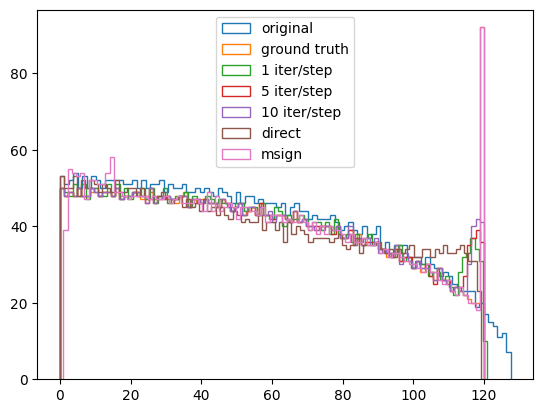

In [5]:
import matplotlib.pyplot as plt

cap = 120
d = {}

with torch.no_grad():
    U, S, Vh = torch.linalg.svd(mat)
    original = S.cpu()

    ground_truth = torch.clamp(S, max=cap).cpu()
    # mat_capped = U @ torch.diag(S_capped) @ Vh

    mat_capped = spectral_chisel.direct_hard_cap(mat, cap)
    direct = torch.linalg.svdvals(mat_capped).cpu()
    
    mat_capped = spectral_chisel.msign_hard_cap(mat, cap)
    msign = torch.linalg.svdvals(mat_capped).cpu()
    
    for i in [1,5,10]:
        hammered = torch.clone(mat)
        sc = spectral_chisel.SpectralChisel(hammered)
        hammered = sc.hammer(hammered, s_max=cap, steps=n, iter_per_step=i)
        d[i] = torch.linalg.svdvals(hammered).cpu()

# Marchenko-Pastur distribution for large n, m:
# https://en.wikipedia.org/wiki/Marchenko%E2%80%93Pastur_distribution
plt.hist(original, bins=100, histtype='step', label='original')
plt.hist(ground_truth, bins=100, histtype='step', label='ground truth')

for i, s in d.items():
    plt.hist(s, bins=100, histtype='step', label=f'{i} iter/step')

plt.hist(direct, bins=100, histtype='step', label='direct')
plt.hist(msign, bins=100, histtype='step', label='msign')

plt.legend()
plt.show()

# Halving / Quartering the number of steps really hurts the result:

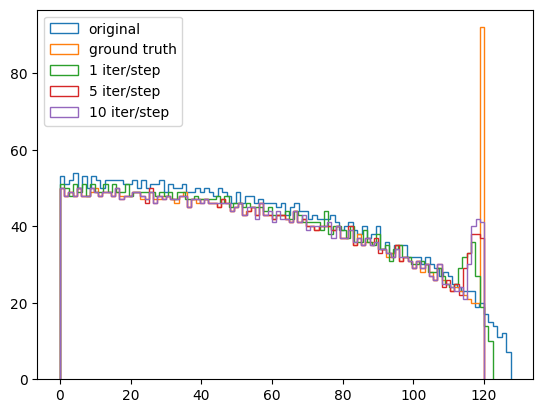

In [6]:
d = {}

with torch.no_grad():
    for i in [1,5,10]:
        hammered = torch.clone(mat)
        sc = spectral_chisel.SpectralChisel(hammered)
        hammered = sc.hammer(hammered, s_max=cap, steps=n // 2, iter_per_step=i)
        d[i] = torch.linalg.svdvals(hammered).cpu()

# Marchenko-Pastur distribution for large n, m:
# https://en.wikipedia.org/wiki/Marchenko%E2%80%93Pastur_distribution
plt.hist(original, bins=100, histtype='step', label='original')

plt.hist(ground_truth, bins=100, histtype='step', label='ground truth')
for i, s in d.items():
    plt.hist(s, bins=100, histtype='step', label=f'{i} iter/step')

plt.legend()
plt.show()

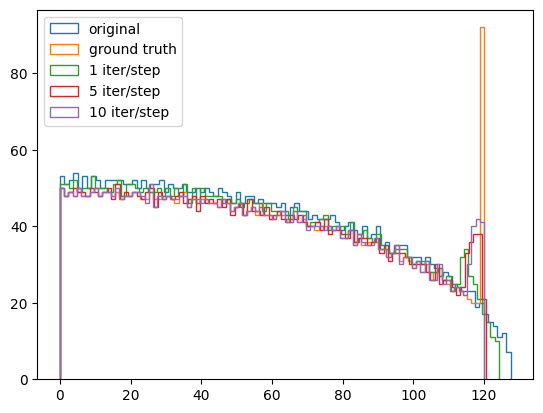

In [7]:
d = {}

with torch.no_grad():
    for i in [1,5,10]:
        hammered = torch.clone(mat)
        sc = spectral_chisel.SpectralChisel(hammered)
        hammered = sc.hammer(hammered, s_max=cap, steps=n // 4, iter_per_step=i)
        d[i] = torch.linalg.svdvals(hammered).cpu()

# Marchenko-Pastur distribution for large n, m:
# https://en.wikipedia.org/wiki/Marchenko%E2%80%93Pastur_distribution
plt.hist(original, bins=100, histtype='step', label='original')

plt.hist(ground_truth, bins=100, histtype='step', label='ground truth')
for i, s in d.items():
    plt.hist(s, bins=100, histtype='step', label=f'{i} iter/step')

plt.legend()
plt.show()

# Reusing the dominant singular vector still helps:

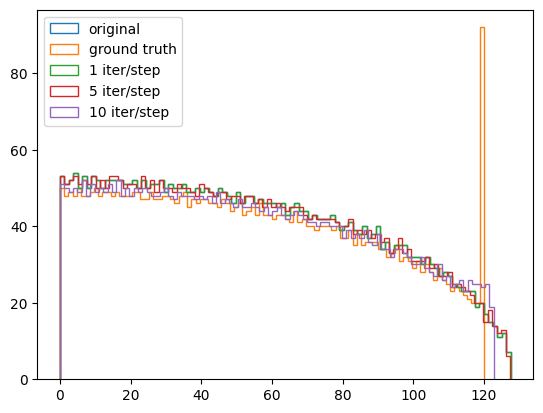

In [8]:
d = {}

with torch.no_grad():
    for i in [1,5,10]:
        hammered = torch.clone(mat)
        for _ in range(n):
            v = torch.normal(0, m**-0.5, (m,)).to(mat)
            v = spectral_chisel.power_iter(hammered, v, i - 1)
            u = hammered @ v
            v = hammered.mT @ u
            v_norm, u_norm = torch.linalg.vector_norm(v), torch.linalg.vector_norm(u)
            v /= v_norm
            u /= u_norm
            spectral_norm = v_norm / u_norm
            hammered -= max(0, spectral_norm - cap) * torch.outer(u, v)
        d[i] = torch.linalg.svdvals(hammered).cpu()

# Marchenko-Pastur distribution for large n, m:
# https://en.wikipedia.org/wiki/Marchenko%E2%80%93Pastur_distribution
plt.hist(original, bins=100, histtype='step', label='original')

plt.hist(ground_truth, bins=100, histtype='step', label='ground truth')
for i, s in d.items():
    plt.hist(s, bins=100, histtype='step', label=f'{i} iter/step')

plt.legend()
plt.show()

# Fun result for repeated spectral decay:

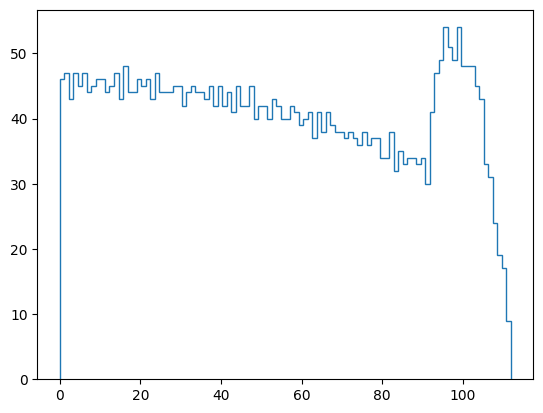

In [9]:
with torch.no_grad():
    decayed = torch.clone(mat)
    sc = spectral_chisel.SpectralChisel(decayed)
    decayed = sc.decay(decayed, wd=0.01, steps=n)
    s_decayed = torch.linalg.svdvals(decayed).cpu()

plt.hist(s_decayed, bins=100, histtype='step')
plt.show()